<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/image-classification/face-emotion.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/image-classification/face-emotion.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Face Emotion Classification



## 1. Setup

In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

print(f"System version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

System version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Tensorflow version: 2.4.1


## 2. Dataset

[Facial Expression Recognition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) data consists of 48x48 pixel grayscale images of faces. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

In this tutorial, we adapt the original dataset to form a binary classification task which is categorizing each face in to one of two categories (0=Sad, 1=Happy).

In [ ]:
# Download data
!curl -L 'https://static.preferred.ai/tutorial/face-emotion/data.zip' -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.8M  100  9.8M    0     0  2772k      0  0:00:03  0:00:03 --:--:-- 2772k


In [ ]:
!unzip -q data.zip

replace data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/images/0/2428.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls data/images/

0  1


### Prepare the data

Let's use 90% of the data for model training and 10% for model validation.

In [ ]:
val_size = 0.1  # @param
batch_size = 32  # @param
img_height = 48  # @param
img_width = 48  # @param

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",
  validation_split=val_size,
  subset="training",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",
  validation_split=val_size,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

# optimize data loading for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9660 files belonging to 2 classes.
Using 8694 files for training.
Found 9660 files belonging to 2 classes.
Using 966 files for validation.


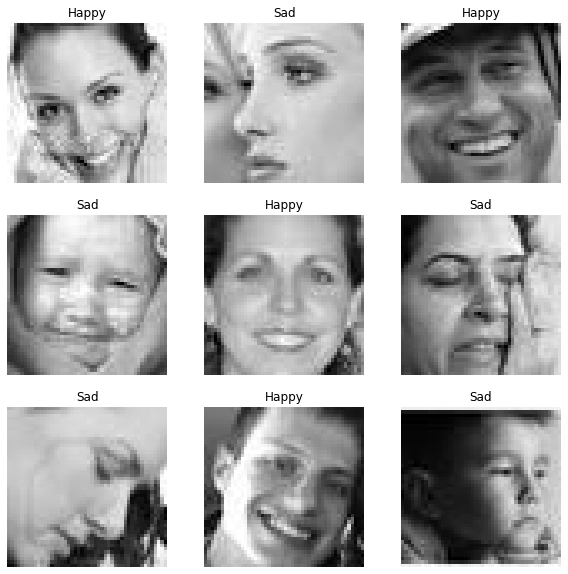

In [ ]:
class_names = ['Sad', "Happy"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8").reshape(48, 48), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 3. Multilayer Perceptron (MLP)


In [ ]:
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 0.01  # @param

mlp_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),                        
  layers.Flatten(),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="MLP")

mlp_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate,  momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

mlp_model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 48, 48, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 48, 48, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258     

In [ ]:
mlp_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
272/272 [==============================] - 4s 11ms/step - loss: 0.6769 - accuracy: 0.6010 - val_loss: 0.5762 - val_accuracy: 0.7122
Epoch 2/20
272/272 [==============================] - 1s 2ms/step - loss: 0.5854 - accuracy: 0.6887 - val_loss: 0.5505 - val_accuracy: 0.7371
Epoch 3/20
272/272 [==============================] - 1s 2ms/step - loss: 0.5566 - accuracy: 0.7162 - val_loss: 0.5445 - val_accuracy: 0.7215
Epoch 4/20
272/272 [==============================] - 1s 2ms/step - loss: 0.5393 - accuracy: 0.7246 - val_loss: 0.5258 - val_accuracy: 0.7350
Epoch 5/20
272/272 [==============================] - 1s 2ms/step - loss: 0.5178 - accuracy: 0.7390 - val_loss: 0.5226 - val_accuracy: 0.7453
Epoch 6/20
272/272 [==============================] - 1s 3ms/step - loss: 0.5094 - accuracy: 0.7435 - val_loss: 0.5232 - val_accuracy: 0.7453
Epoch 7/20
272/272 [==============================] - 1s 2ms/step - loss: 0.4950 - accuracy: 0.7626 - val_loss: 0.5240 - val_accuracy: 0.7453
Epoch

## 4. Shallow CNN



In [ ]:
filters = 32  # @param
kernel_size = [3, 3]  # @param
strides = 1 # @param
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 0.01 # @param

shallow_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),  
  layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Flatten(),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="Shallow-CNN")

shallow_cnn_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate, momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

shallow_cnn_model.summary()

Model: "Shallow-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 48, 48, 1)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               

In [ ]:
shallow_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
272/272 [==============================] - 3s 4ms/step - loss: 0.6557 - accuracy: 0.6080 - val_loss: 0.5294 - val_accuracy: 0.7536
Epoch 2/20
272/272 [==============================] - 1s 3ms/step - loss: 0.5523 - accuracy: 0.7168 - val_loss: 0.4933 - val_accuracy: 0.7671
Epoch 3/20
272/272 [==============================] - 1s 3ms/step - loss: 0.5070 - accuracy: 0.7385 - val_loss: 0.4848 - val_accuracy: 0.7764
Epoch 4/20
272/272 [==============================] - 1s 3ms/step - loss: 0.4739 - accuracy: 0.7675 - val_loss: 0.4668 - val_accuracy: 0.7743
Epoch 5/20
272/272 [==============================] - 1s 3ms/step - loss: 0.4331 - accuracy: 0.7900 - val_loss: 0.4716 - val_accuracy: 0.7764
Epoch 6/20
272/272 [==============================] - 1s 3ms/step - loss: 0.4211 - accuracy: 0.7978 - val_loss: 0.4638 - val_accuracy: 0.7940
Epoch 7/20
272/272 [==============================] - 1s 3ms/step - loss: 0.3867 - accuracy: 0.8247 - val_loss: 0.4453 - val_accuracy: 0.8002
Epoch 

## 5. Deep CNN

In [ ]:
filters = 32  # @param
kernel_size = [3, 3]  # @param
strides = 1 # @param
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 0.01 # @param

deep_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),
  layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(2 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Flatten(),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="Deep-CNN")

deep_cnn_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate,  momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

deep_cnn_model.summary()

Model: "Deep-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_2 (RandomFlip)   (None, 48, 48, 1)         0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       738

In [ ]:
history = deep_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
272/272 [==============================] - 2s 5ms/step - loss: 0.6830 - accuracy: 0.5475 - val_loss: 0.5652 - val_accuracy: 0.7153
Epoch 2/20
272/272 [==============================] - 1s 5ms/step - loss: 0.5806 - accuracy: 0.6979 - val_loss: 0.4862 - val_accuracy: 0.7619
Epoch 3/20
272/272 [==============================] - 1s 5ms/step - loss: 0.4946 - accuracy: 0.7606 - val_loss: 0.4329 - val_accuracy: 0.7878
Epoch 4/20
272/272 [==============================] - 1s 5ms/step - loss: 0.4269 - accuracy: 0.7979 - val_loss: 0.4240 - val_accuracy: 0.7930
Epoch 5/20
272/272 [==============================] - 1s 5ms/step - loss: 0.3799 - accuracy: 0.8219 - val_loss: 0.4026 - val_accuracy: 0.8178
Epoch 6/20
272/272 [==============================] - 1s 5ms/step - loss: 0.3548 - accuracy: 0.8436 - val_loss: 0.3914 - val_accuracy: 0.8323
Epoch 7/20
272/272 [==============================] - 1s 5ms/step - loss: 0.3262 - accuracy: 0.8525 - val_loss: 0.4287 - val_accuracy: 0.8126
Epoch 

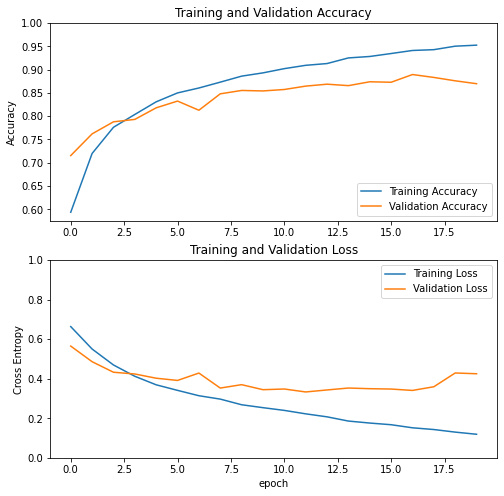

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 6. Visualization of Learned CNN Filters

Here we visualize the Deep CNN model with saliency map of images using [Guided Backpropagation](https://arxiv.org/abs/1412.6806) technique, and the activation maps of the 4th convolutional layer of the network.

We may notice that the model focuses more on the mouth with Happy emotion, while other parts of the face are paid attention with Sad emotion.

| Input Image                                                                                                                      | Saliency Map                                                                                                                                  | Activation Maps of the 4th Convolutional Layer                                                                                       | Label |
| :------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :------------------------------------------------------------------------------------------------------------------------------------: | :---: |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/82.jpg)  | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_82.jpg)  | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_82.jpg)  | Happy |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/130.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_130.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_130.jpg) | Sad   |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/791.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_791.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_791.jpg) | Happy |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/607.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_607.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_607.jpg) | Sad   |

Please refer to this [code](https://github.com/PreferredAI/tutorials/blob/7ccc67cde2408c873a6cba66b58ec56dee236a17/image-classification/face-emotion/src/visualize.py) for more details.